In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

# CRF 층 설치하기

**1) CRF 층을 손쉽게 사용하기 위한 keras-crf를 설치**

In [ ]:
!pip install keras-crf==0.3.0

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
# 모델 평가
!pip install seqeval

     |████████████████████████████████| 43 kB 828 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=487266b3ca3a8ba64c2e4741beffd6bbf3a7f3836117a70c4fa7f4ce54510c12
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
!pip list | grep keras-crf

keras-crf                     0.3.0


# 또다른 개체명 인식 데이터에 대한 이해와 전처리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

**1) Annotated Corpus 데이터 다운로드**

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="ner_dataset.csv")

('ner_dataset.csv', <http.client.HTTPMessage at 0x7f5243b2f950>)

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

**2) 샘플 5개 출력**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **t번째 문장을 단어 토큰화 후 각 행으로 나눠놓은 데이터이기 때문에**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **Sentence: t부터 Null 값이 나오다가 Sentence: t+1이 나오기 전까지의 모든 행은 기존에 하나의 문장임**

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


**3) 데이터의 행의 개수를 확인**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **이는 문장 1개를 다수의 행들로 나누어 놓은 것이므로 다시 1개의 행으로 병합하는 작업을 하면 최종 샘플의 수는 이보다 적음**

In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


**4) 결측값 유무 출력**

In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

**5) 전체 데이터에서 중복을 허용하지 않고 유일한 값의 개수를 확인**

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


**6) 17개의 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **아무런 태깅도 의미하지 않는 O가 가장 많은 개수를 차지함**

In [ ]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


**7) Null을 제거하도록 함**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **t번째 문장에 속하면서 Null 값을 가진 샘플들은 전부 첫 번째 열에 Sentence: t의 값이 들어가게 됨**

In [ ]:
data = data.fillna(method="ffill")

In [ ]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


**8) 모든 단어를 소문자화하여 단어의 개수를 줄이기**

In [ ]:
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


**9) 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍으로 묶기**

In [ ]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


**10) zip() 함수를 이용해서 단어 부분과 개체명 태깅 정보 부분을 분리시켜 sentences와 ner_tags에 저장**

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**11) 전체 데이터의 길이 분포 확인**

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


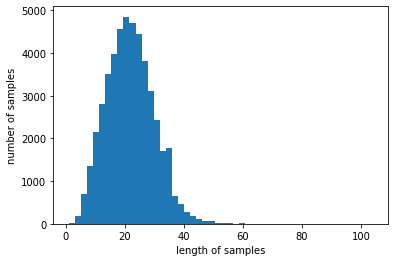

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**12) 케라스 토크나이저를 통해 문장 데이터와 레이블에 해당되는 개체명 태깅 정보에 대해 정수 인코딩 진행**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
        **src_tokenizer를 만들 때 인자로 oov_token='OOV'를 선택했으므로 인덱스1에 단어 'OOV'가 할당됨**

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


**13) 정수 인코딩을 수행하여 문장 데이터는 X_data에, 개체명 태깅 데이터는 y_data에 저장**

In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


**14) 인덱스로부터 단어를 리턴하는 index_to_word와 인덱스로부터 개체명 태깅 정보를 리턴하는 index_to_ner을 생성**

In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


**15) index_to_word를 통해 정수 인코딩 된 첫 번째 샘플을 다시 디코딩하여 변환해보기**

In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


**16) 대부분의 샘플은 길이가 40~60에 분포하므로 X_train과 y_train의 모든 길이를 임의로 70으로 맞추기**

In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
print(X_data.shape)
print(y_data.shape)

(47959, 70)
(47959, 70)


**17) 훈련 데이터와 테스트 데이터를 8:2 비율로 분리**

In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

**18) 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행**

In [ ]:
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


# 문자 임베딩을 위한 추가 전처리

**1) 전체 데이터의 모든 단어들을 문자 레벨로 분해하여 문자 집합 생성**

In [ ]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


**2) 문자 집합으로부터 문자를 정수로 변환할 수 있는 char_to_index와 반대로 정수로부터 문자를 얻는 index_to_char 생성**

In [ ]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [ ]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [ ]:
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


**3) 단어를 표현하는 문자 시퀀스의 최대 길이를 15로 제한 후 패딩**

In [ ]:
max_len_char = 15

def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', value = 0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]  
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:
      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)
  return char_data

**4) 동일한 문장에 대해서 단어 단위 정수 인코딩과 문자 단위 정수 인코딩의 차이를 확인**

In [ ]:
X_char_data = integer_coding(sentences)

In [ ]:
# 정수 인코딩 이전의 기존 문장
print(sentences[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
print(X_data[0])

[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(X_char_data[0])

[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 51 48 46  0  0  0  0  0  0  0  0  0

**5) X_data는 뒤에 0으로 패딩되어 길이가 70인 것에 비해 X_char_data는 현재 0번 단어는 무시되어 길이가 70이 아니므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **길이 70으로 맞춰주기 위해서 문장 길이 방향으로도 패딩을 해줌**

In [ ]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

**6) 단어 단위 정수 인코딩 결과는 X_train, y_train, X_text, y_text로 훈련 데이터와 테스트 데이터가 분리된 상태이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **문자 단위 정수 인코딩 결과에 대해서도 X_char_train, X_char_test로 분리해줌**

In [ ]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

In [ ]:
X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [ ]:
print(X_train[0])

[ 150  928  361   17 2624    9 4131 3567    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


**7) 첫 번째 훈련 샘플의 첫 번째 단어인 150번이 어떤 단어였는지 확인하고**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **첫 번째 훈련 샘플의 첫 번째 단어의 문자 정수 인코딩 결과로부터 같은 단어로 일치하는지 확인**

In [ ]:
print(index_to_word[150])

soldiers


In [ ]:
print(X_char_train[0])

[[52 48 45 ...  0  0  0]
 [51 38 53 ...  0  0  0]
 [39 42 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [ ]:
print(X_char_train[0][0])

[52 48 45 37 42 38 51 52  0  0  0  0  0  0  0]


In [ ]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# BiLSTM-CNN을 이용한 개체명 인식

In [ ]:
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report

**1) 하나의 단어는 문자 단위로 토큰화되었고, 토큰화된 각 문자는 전처리를 통해 정수로 맵핑된 상태이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터가 되게 됨**<br>
**2) 이후 커널의 크기가 3이고 해당 커널은 총 30개 사용하는 1D 합성곱 층의 입력으로 사용되어**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **하나의 단어에 대한 단어 벡터를 결과로 얻게 됨**<br>
**3) 해당 단어 벡터는 워드 임베딩 과정을 통해 얻은 단어의 임베딩 벡터와 연결되게 되어 양방향 LSTM의 입력으로 사용됨**<br>
**4) 임베딩 벡터의 차원은 128, LSTM의 은닉 상태의 크기는 64로 지정**<br>
**5) 다 대 다 문제이므로 LSTM의 return_squences의 값은 True로 지정하고 양방향 사용을 위해 Bidirectional() 사용**<br>
**6) LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용해야 하므로 출력층에 TimeDistributed() 사용**<br>
**7) 모든 시점에 대해서 개체명 레이블의 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **출력층에 소프트맥스 회귀, 활성화 함수로 소프트맥스 함수, 손실 함수로 크로스 엔트로피 함수를 사용**

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_2 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                            

**8) EarlyStopping을 사용해 검증 데이터 손실이 증가하면 과적합 징후이므로 4회 증가하면 학습을 조기 종료하도록 함**<br>
**9) ModelCheckpoint를 사용해 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장함**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

**10) validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리하여 사용해 훈련이 적절히 되고 있는지 확인**<br>
**11) 배치 크기는 128로 하여 15번의 에포크를 수행**

In [ ]:
history = model.fit([X_train, X_char_train], y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=1, callbacks=[es, mc])

Epoch 1/15
270/270 [==============================] - ETA: 0s - loss: 0.2072 - acc: 0.9474
Epoch 00001: val_acc improved from -inf to 0.97665, saving model to bilstm_cnn.h5
270/270 [==============================] - 23s 47ms/step - loss: 0.2072 - acc: 0.9474 - val_loss: 0.0852 - val_acc: 0.9766
Epoch 2/15
269/270 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9820
Epoch 00002: val_acc improved from 0.97665 to 0.98477, saving model to bilstm_cnn.h5
270/270 [==============================] - 12s 43ms/step - loss: 0.0635 - acc: 0.9820 - val_loss: 0.0521 - val_acc: 0.9848
Epoch 3/15
270/270 [==============================] - ETA: 0s - loss: 0.0453 - acc: 0.9867
Epoch 00003: val_acc improved from 0.98477 to 0.98625, saving model to bilstm_cnn.h5
270/270 [==============================] - 12s 44ms/step - loss: 0.0453 - acc: 0.9867 - val_loss: 0.0454 - val_acc: 0.9862
Epoch 4/15
270/270 [==============================] - ETA: 0s - loss: 0.0381 - acc: 0.9886
Epoch 00004: va

**12) 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러오기**

In [ ]:
model = load_model('bilstm_cnn.h5')

**13) 테스트 데이터의 임의의 인덱스 13번 샘플에 대해서 실제값과 예측값을 비교**

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


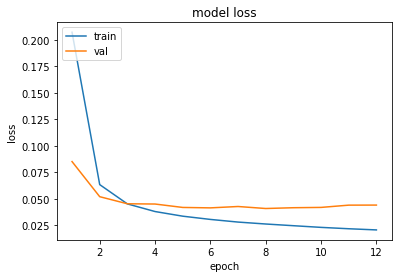

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
    result = []
    for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
        temp = []
        for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
            pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            temp.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
        result.append(temp)
    return result

**14) 테스트 데이터에 대해서 성능을 측정하기 위해 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻기**

In [ ]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.36      0.27      0.31        52
         geo       0.82      0.86      0.84      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.62      0.14      0.22        37
         org       0.61      0.56      0.59      4033
         per       0.73      0.72      0.73      3545
         tim       0.87      0.84      0.86      4067

   micro avg       0.80      0.79      0.79     22562
   macro avg       0.62      0.54      0.56     22562
weighted avg       0.79      0.79      0.79     22562



**15) 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 f1-score를 계산**

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 79.3%


#BiLSTM-CNN-CRF를 이용한 개체명인식

In [ ]:
import tensorflow as tf
from keras_crf import CRFModel

**1) 하나의 단어는 문자 단위로 토큰화되었고, 토큰화된 각 문자는 전처리를 통해 정수로 맵핑된 상태이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터가 되게 됨**<br>
**2) 이후 커널의 크기가 3이고 해당 커널은 총 30개 사용하는 1D 합성곱 층의 입력으로 사용되어**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **하나의 단어에 대한 단어 벡터를 결과로 얻게 됨**<br>
**3) 해당 단어 벡터는 워드 임베딩 과정을 통해 얻은 단어의 임베딩 벡터와 연결되게 되어 양방향 LSTM의 입력으로 사용됨**<br>
**4) 임베딩 벡터의 차원은 128, LSTM의 은닉 상태의 크기는 64로 지정**<br>
**5) 다 대 다 문제이므로 LSTM의 return_squences의 값은 True로 지정하고 양방향 사용을 위해 Bidirectional() 사용**<br>
**6) LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용해야 하므로 출력층에 TimeDistributed() 사용**<br>
**7) 모든 시점에 대해서 개체명 레이블의 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **최종 출력층을 CRF층으로 하여 CRF층에 분류해야 하는 선택지 개수를 의미하는 tag_size를 전달**

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(dropout_ratio)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=kernel_size, filters=num_filters, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(dropout_ratio)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(hidden_units, return_sequences=True, dropout=dropout_ratio))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[words_input, character_input], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_4 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                        

**8) EarlyStopping을 사용해 검증 데이터 손실이 증가하면 과적합 징후이므로 4회 증가하면 학습을 조기 종료하도록 함**<br>
**9) ModelCheckpoint를 사용해 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장함**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

**10) validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리하여 사용해 훈련이 적절히 되고 있는지 확인**<br>
**11) 배치 크기는 128로 하여 15번의 에포크를 수행**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**이때 CRF층은 원-핫 인코딩된 레이블을 지원하지 않으므로 y_train이 아니라 y_train_int를 사용**

In [ ]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9270 - loss: 20.0089
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.96776, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 59s 193ms/step - decode_sequence_accuracy: 0.9270 - loss: 19.9610 - val_decode_sequence_accuracy: 0.9678 - val_loss: 7.4661
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9787 - loss: 5.1367
Epoch 00002: val_decode_sequence_accuracy improved from 0.96776 to 0.98258, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 45s 167ms/step - decode_sequence_accuracy: 0.9787 - loss: 5.1319 - val_decode_sequence_accuracy: 0.9826 - val_loss: 4.0034
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9856 - loss: 3.1769
Epoch 00003: val_decode_sequence_accuracy improved from 0.98258 to 0.98532, saving model to bilstm_cnn_

**12) 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러오기**

In [ ]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

**13) 테스트 데이터의 임의의 인덱스 13번 샘플에 대해서 실제값과 예측값을 비교**

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0] 
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


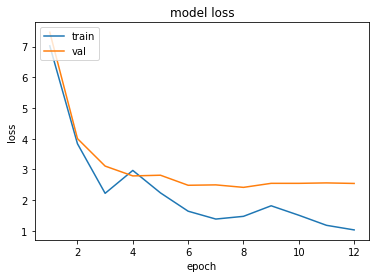

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**14) 테스트 데이터에 대해서 성능을 측정하기 위해 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻기**

In [ ]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.00      0.00      0.00        52
         geo       0.80      0.89      0.84      7620
         gpe       0.94      0.94      0.94      3145
         nat       1.00      0.16      0.28        37
         org       0.68      0.55      0.61      4033
         per       0.79      0.73      0.76      3545
         tim       0.88      0.84      0.86      4067

   micro avg       0.82      0.80      0.81     22562
   macro avg       0.64      0.51      0.54     22562
weighted avg       0.81      0.80      0.80     22562



**15) 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 f1-score를 계산**

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 80.6%


# BiLSTM-BiLSTM-CRF을 이용한 개체명 인식

**1) 하나의 단어는 문자 단위로 토큰화되었고, 토큰화된 각 문자는 전처리를 통해 정수로 맵핑된 상태이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **정수로 맵핑된 각 문자는 임베딩 층을 통과하면 64차원의 벡터가 되게 됨**<br>
**2) 이후 양방향 LSTM의 입력으로 사용되고 이때 임베딩 벡터의 차원은 128, LSTM의 은닉 상태의 크기는 64로 지정**<br>
**3) 해당 LSTM은 다 대 일 구조로 순방향 LSTM의 은닉 상태와 역방향 LSTM의 은닉 상태가 연결된 값이**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **양방향 LSTM의 출력이 되고 해당 출력을 하나의 단어에 대한 단어 벡터로 간주되게 됨**<br>
**4) 해당 단어 벡터는 워드 임베딩 과정을 통해 얻은 단어의 임베딩 벡터와 연결되게 되어**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **개체명 인식을 위한 양방향 LSTM의 입력으로 사용**<br>
**5) 다 대 다 문제이므로 LSTM의 return_squences의 값은 True로 지정하고 양방향 사용을 위해 Bidirectional() 사용**<br>
**6) LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용해야 하므로 출력층에 TimeDistributed() 사용**<br>
**7) 모든 시점에 대해서 개체명 레이블의 개수만큼의 선택지 중 하나를 예측하는 다중 클래스 분류 문제를 수행하는 모델이므로**<br>
&nbsp;&nbsp;&nbsp;&nbsp;
     **최종 출력층을 CRF층으로 하여 CRF층에 분류해야 하는 선택지 개수를 의미하는 tag_size를 전달**

In [ ]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
word_embeddings = concatenate([word_embeddings, char_embeddings])

word_embeddings = Dropout(dropout_ratio)(word_embeddings)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(word_embeddings)
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

model.summary()

Model: "crf_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 word_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 char_embedding (Embedding)     (None, None, None,   4736        ['char_input[0][0]']             
                                64)                                                               
                                                                                        

**8) EarlyStopping을 사용해 검증 데이터 손실이 증가하면 과적합 징후이므로 4회 증가하면 학습을 조기 종료하도록 함**<br>
**9) ModelCheckpoint를 사용해 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장함**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

**10) validation_split=0.1을 사용하여 훈련 데이터의 10%를 검증 데이터로 분리하여 사용해 훈련이 적절히 되고 있는지 확인**<br>
**11) 배치 크기는 128로 하여 15번의 에포크를 수행**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**이때 CRF층은 원-핫 인코딩된 레이블을 지원하지 않으므로 y_train이 아니라 y_train_int를 사용**

In [ ]:
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9263 - loss: 22.6385
Epoch 00001: val_decode_sequence_accuracy improved from -inf to 0.97024, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 62s 195ms/step - decode_sequence_accuracy: 0.9263 - loss: 22.5786 - val_decode_sequence_accuracy: 0.9702 - val_loss: 7.3148
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9787 - loss: 4.9090
Epoch 00002: val_decode_sequence_accuracy improved from 0.97024 to 0.98270, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 47s 173ms/step - decode_sequence_accuracy: 0.9787 - loss: 4.9062 - val_decode_sequence_accuracy: 0.9827 - val_loss: 3.7907
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9852 - loss: 3.0332
Epoch 00003: val_decode_sequence_accuracy improved from 0.98270 to 0.98497, saving model to bilst

**12) 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치를 불러오기**

In [ ]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

**13) 테스트 데이터의 임의의 인덱스 13번 샘플에 대해서 실제값과 예측값을 비교**

In [ ]:
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
true = np.argmax(y_test[i], -1) # 원-핫 벡터를 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], true, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


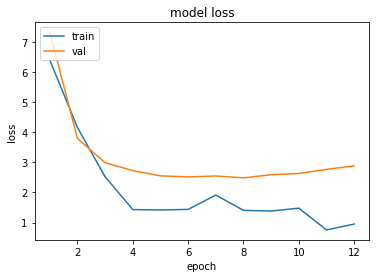

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**14) 테스트 데이터에 대해서 성능을 측정하기 위해 테스트 데이터에 대한 예측 시퀀스인 y_predicted를 얻기**

In [ ]:
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.44      0.06      0.11        63
         eve       0.70      0.27      0.39        52
         geo       0.83      0.87      0.85      7620
         gpe       0.95      0.94      0.94      3145
         nat       0.39      0.19      0.25        37
         org       0.71      0.55      0.62      4033
         per       0.79      0.74      0.76      3545
         tim       0.88      0.84      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.71      0.56      0.60     22562
weighted avg       0.82      0.79      0.81     22562



**15) 예측값과 실제값에 대한 태깅 정보 시퀀스를 얻은 후 f1-score를 계산**

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 81.1%
